## **CNN**

In this section, we implement a Convolutional Neural Network (CNN) to classify support tickets into predefined categories. CNNs are particularly effective for text classification tasks due to their ability to capture local patterns such as key phrases and n-grams.

We use preprocessed text data and pre-trained GloVe embeddings to enrich word representations. The model architecture includes multiple convolutional layers with varying kernel sizes, followed by max pooling and fully connected layers. Regularization techniques such as dropout, batch normalization, and L2 penalties are applied to improve generalization and prevent overfitting.

This CNN aims to accurately predict the category of each ticket based on its textual content, and the final model is evaluated on both validation and test datasets.

#### Imports

In [75]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [44]:
# Tokenization and Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [45]:
# Encode target labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [46]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

In [47]:
# Model architecture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout,
                                     Concatenate, SpatialDropout1D, BatchNormalization)
from tensorflow.keras.regularizers import l2

In [48]:
# Callbacks for training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [49]:
# Ensuring reproducibility by setting seeds
SEED = 40
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

#### Load Datasets

In [50]:
# Loading training, validation, and test data
train_data = pd.read_csv("/content/ticket_train.csv", sep=";")
valid_data = pd.read_csv("/content/ticket_valid.csv", sep=";")
test_data  = pd.read_csv("/content/ticket_test.csv", sep=";")

In [51]:
# Extract input texts and labels from each dataset
x_train = train_data["text_cleaned"].astype(str).values
y_train = train_data["grouped_queue"].values

x_valid = valid_data["text_cleaned"].astype(str).values
y_valid = valid_data["grouped_queue"].values

x_test  = test_data["text_cleaned"].astype(str).values
y_test  = test_data["grouped_queue"].values

#### Tokenization and Padding

The parameters `max_vocab = 11000`, `max_length = 400`, and `oov_tok = "<OOV>"` are used to configure the text preprocessing for the model. `max_vocab` sets the maximum number of unique words to retain based on frequency (following the EDA results,vthe top 11,000 words), reducing model complexity. `max_length` defines the maximum length of input sequences, ensuring consistency in text size by padding or truncating longer texts. Finally, `oov_tok` represents the token used for any words not seen during training, allowing the model to handle out-of-vocabulary words gracefully.

In [52]:
max_vocab = 11000
max_length = 400
oov_tok = "<OOV>"

In [53]:
# Initialize and fit the tokenizer on training data
tokenizer = Tokenizer(num_words=max_vocab, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

In [54]:
# Convert texts to padded sequences
x_train_pad = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_length, padding="post")
x_valid_pad = pad_sequences(tokenizer.texts_to_sequences(x_valid), maxlen=max_length, padding="post")
x_test_pad  = pad_sequences(tokenizer.texts_to_sequences(x_test),  maxlen=max_length, padding="post")

#### Enconde Target Labels

In [55]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)
y_test_enc  = label_encoder.transform(y_test)

In [56]:
# Convert labels to one-hot encoded format for classification
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_enc, num_classes)
y_valid_cat = to_categorical(y_valid_enc, num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes)

#### Class weights

When some classes are underrepresented, the model may become biased towards the majority class. By assigning higher weights to the underrepresented classes, the model gives them more importance during training, improving its ability to learn from these classes.

`cw_dict` stores these weights in a dictionary format, which is later used during model training to adjust the loss function accordingly.

In [57]:
# Calculate balanced weights to handle class imbalance
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_enc), y=y_train_enc)
cw_dict = dict(enumerate(cw))

#### Load GloVe Embeddings

In this model we used pre-trained GloVe (Global Vectors for Word Representation) embeddings. GloVe is an unsupervised learning algorithm for generating word embeddings, which are dense vector representations of words. The file `glove.6B.300d.txt` contains the word vectors, where each word in the vocabulary is represented by a 300-dimensional vector.

- `embedding_dim = 300`: Specifies the dimensionality of the word vectors, which in this case is 300. This means each word will be represented by a 300-dimensional vector.

Using pre-trained embeddings like GloVe allows the model to leverage rich, contextual information about words that were learned from vast amounts of text, which can significantly improve the performance of natural language processing (NLP) models.

In [58]:
# Load pretrained GloVe embeddings
embedding_dim = 300
glove_path = "/content/glove.6B.300d.txt"

In [59]:
# Create embedding index from GloVe file
embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector


In [60]:
# Build embedding matrix
word_index = tokenizer.word_index
num_words = min(max_vocab, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < max_vocab:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


#### Model Architecture

This model processes input sequences of length 400, starting with an embedding layer that maps tokens to 300-dimensional GloVe vectors. To prevent overfitting, SpatialDropout1D is applied to the embeddings. It uses three Conv1D layers with different kernel sizes (3, 4, 5) for feature extraction, followed by GlobalMaxPooling1D to capture the most important features from each filter. These features are concatenated and passed through dense layers (128 and 64 units), with batch normalization and dropout for regularization. The final output layer has 3 units for class predictions using softmax activation. The model has 3,364,327 parameters, primarily trainable, combining convolutional and dense layers for effective text classification.

In [61]:
# Define input layer
inputs = Input(shape=(max_length,))

In [62]:
# Embedding layer with pretrained weights and L2 regularization
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim,
                      weights=[embedding_matrix], trainable=True, embeddings_regularizer=l2(1e-5))(inputs)


In [63]:
# Apply spatial dropout for regularization
x = SpatialDropout1D(0.4)(embedding)

In [64]:
# Apply parallel Conv1D layers with different kernel sizes
conv_3 = Conv1D(128, 3, activation="relu", kernel_regularizer=l2(1e-5))(x)
conv_4 = Conv1D(128, 4, activation="relu", kernel_regularizer=l2(1e-5))(x)
conv_5 = Conv1D(128, 5, activation="relu", kernel_regularizer=l2(1e-5))(x)

In [65]:
# Max pooling on each conv output
pool_3 = GlobalMaxPooling1D()(conv_3)
pool_4 = GlobalMaxPooling1D()(conv_4)
pool_5 = GlobalMaxPooling1D()(conv_5)

In [66]:
# Concatenate pooled outputs
concat = Concatenate()([pool_3, pool_4, pool_5])

In [67]:
# Fully connected layers with batch normalization and dropout
x = Dense(128, activation="relu", kernel_regularizer=l2(1e-5))(concat)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(64, activation="relu", kernel_regularizer=l2(1e-5))(x)
x = Dropout(0.7)(x)


In [68]:
# Output layer
outputs = Dense(num_classes, activation="softmax")(x)


In [69]:
# Compile model
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 400, 300)  │  2,844,900 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_9 │ (None, 400, 300)  │          0 │ embedding_9[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 398, 128)  │    115,328 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 397, 128)  │    153,728 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 396, 128)  │    192,128 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_27[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_28[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_29[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 128)       │     49,280 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_29[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 64)        │      8,256 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 64)        │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 3)         │        195 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,364,327 (12.83 MB)

 Trainable params: 3,364,071 (12.83 MB)

 Non-trainable params: 256 (1.00 KB)

#### Callbacks for training

In [70]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)

#### Train

In [71]:
history = model.fit(
    x_train_pad, y_train_cat,
    epochs=45,
    batch_size=10,
    validation_data=(x_valid_pad, y_valid_cat),
    callbacks=[early_stop, reduce_lr],
    class_weight=cw_dict,
    verbose=2
)

Epoch 1/45
2758/2758 - 26s - 10ms/step - accuracy: 0.5104 - loss: 2.1952 - val_accuracy: 0.6235 - val_loss: 1.5150 - learning_rate: 1.0000e-03
Epoch 2/45
2758/2758 - 18s - 7ms/step - accuracy: 0.5880 - loss: 1.4054 - val_accuracy: 0.6308 - val_loss: 1.1371 - learning_rate: 1.0000e-03
Epoch 3/45
2758/2758 - 21s - 8ms/step - accuracy: 0.6119 - loss: 1.1176 - val_accuracy: 0.6517 - val_loss: 0.9505 - learning_rate: 1.0000e-03
Epoch 4/45
2758/2758 - 18s - 6ms/step - accuracy: 0.6337 - loss: 0.9881 - val_accuracy: 0.6555 - val_loss: 0.8944 - learning_rate: 1.0000e-03
Epoch 5/45
2758/2758 - 21s - 8ms/step - accuracy: 0.6444 - loss: 0.9322 - val_accuracy: 0.6778 - val_loss: 0.8473 - learning_rate: 1.0000e-03
Epoch 6/45
2758/2758 - 21s - 8ms/step - accuracy: 0.6630 - loss: 0.8927 - val_accuracy: 0.6876 - val_loss: 0.8360 - learning_rate: 1.0000e-03
Epoch 7/45
2758/2758 - 20s - 7ms/step - accuracy: 0.6818 - loss: 0.8648 - val_accuracy: 0.6865 - val_loss: 0.8345 - learning_rate: 1.0000e-03
Epoch

#### Evaluation

In [72]:
test_loss, test_accuracy = model.evaluate(x_test_pad, y_test_cat, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.8515, Test Accuracy: 0.6900


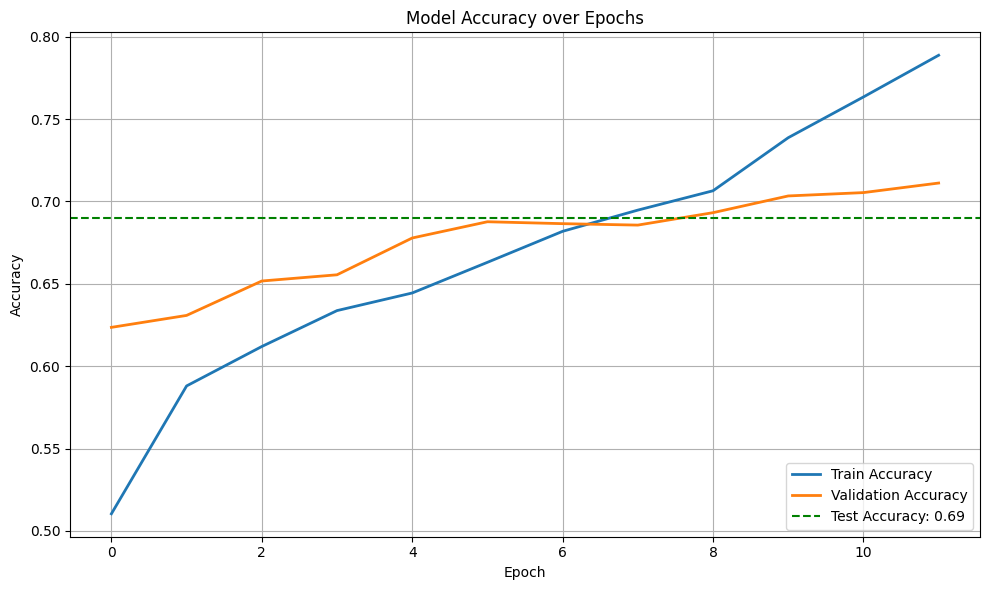

In [73]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)

epochs = len(history.history['accuracy'])
plt.axhline(y=test_accuracy, color='green', linestyle='--', label=f'Test Accuracy: {test_accuracy:.2f}')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Training Accuracy Curve**

*   Starts at around 50% and steadily increases, approaching 80% near the last epoch. This suggests that the model continues to learn with each epoch and has not yet reached its optimal fit on the training set.

**Validation Accuracy Curve**

*   Begins slightly higher than the training curve (around 55%) and rises to about 70% in the later epochs. It stays below the training curve, which is normal and expected: the model generally performs better on the training set than on unseen data (validation).

**Test Accuracy (0.69)**

*   The dashed line around 0.69 is very close to the final validation accuracy (~0.70). This indicates that the performance on the test set is quite similar to that on the validation set, suggesting reasonable generalization with no significant overfitting or underfitting.


**Confusion Matrix**

In [76]:
# Make predictions on the test data
y_pred = model.predict(x_test_pad)

# Get the predicted class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true class labels
y_true = np.argmax(y_test_cat, axis=1)

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


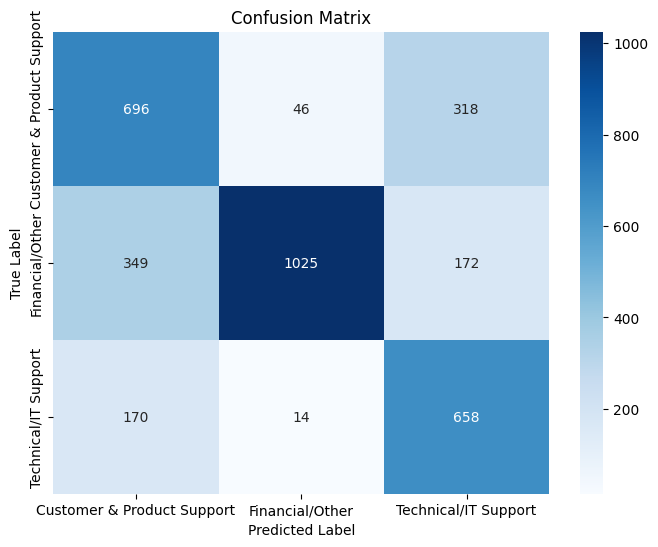

In [77]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Save the model**

In [79]:
model.save("/content/model_cnn_glove.h5")